<h2> Installation et import des packages :</h2>

In [ ]:
! pip install torch
! pip install pandas
! pip install scipy
! pip install collections
! pip install seaborn
! pip install sklearn
! pip install tqdm
! pip install matplotlib
! pip install sklearn
! pip install json
! pip install numpy
! pip install IPython
! pip install copy
! pip install tabulate

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol
import scipy.stats as stats
from scipy.linalg import cholesky
from tqdm import tqdm
from collections import Counter
import torch
from torch import nn
from torch.functional import F
from copy import copy
import seaborn as sns
import json
import scipy
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from IPython.display import Markdown, display
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import plot_confusion_matrix
sns.set_style("whitegrid")

<h2> Utiliser le GPU s'il est disponible sinon utiliser le CPU : </h2> 
L'entrainement avec le GPU s'effectue environ 60 fois plus vite qu'avec le CPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

<h2> Quelques Fonction utiles </h2>

In [4]:
def log_sum_exp_trick(xs):
    '''
    fonction qui prend un nd array : xs et renvoie log(sum(exp(xs)))
    en utilisant la méthode log_sum_exp_trick
    '''
    a = torch.max(xs)
    return a + torch.log(torch.sum(torch.exp(xs - a)))


def vecteur_gaussiens( L, u, loc=0, scale=1):
    '''
    fonction qui prend en entrée
    
    loc : la moyenne definie par defaut à 0
    L : matrice de taille J*J tq L*L.T 
    u : suite de sobol de taille N*J
    
    et genére N vecteurs gaussien quasi aleatoirs de moyenne loc et de covariance cov
    '''

    N, du = u.shape
    dim = L.shape[0]
    if du < dim:
        z = torch.zeros((N, dim)).float().to(device)
        z[:, :du] = stats.norm.ppf(u)
    else:
        z=torch.tensor(stats.norm.ppf(u)).float().to(device)
    
    return loc + scale * (z.float() @ L.float().mT.to(device))


def norm_proba(qk):
    '''
    fonction qui prend un vecteur et le normalise en vecteur de proba (tq sum(qk)=1 )
    '''
    K=len(qk)
    vect_prob = torch.zeros(K).to(device)
    for k in range(K):
        vect_prob[k] = max( qk[k] , 0 )
        
    return vect_prob/vect_prob.sum()

def vect_to_tri(v, tril = True, J= None):
    '''
    prend une vecteur de taille (J**2+J)/2 et renvoie une matrice triangulaire de taille J
    '''
    if J == None :
        n = len(v)
        J = int(np.around((-1+2*np.sqrt(2*n))/2.0))
    tri = torch.zeros((J,J)).to(device)
    if tril : 
        indices = torch.tril_indices(J,J).to(device)
        
    else :
        indices = torch.triu_indices(J,J).to(device)
        
    tri[indices[0], indices[1]] = v
    return tri

def tri_to_vect(L, tril = True):
    '''
    prend une matrice triangulaire de taille J*J et renvoie un vecteur de taile (J**2+J)/2
    '''
    J = L.shape[1]
    n = int((J**2 + J ) / 2.0)
    v = torch.zeros(n).to(device)
    
    if tril : 
        indices = torch.tril_indices(J,J).to(device)
    else :
        indices = torch.triu_indices(J,J).to(device)
        
    v = L[indices[0], indices[1]]
    return v

def replace_tri(L, replace_values, dtype = 'float64', tri = True):
    '''
    prend une matrice triangulaire et remplace les valeur du triangle par replace_values
    '''
    J = L.shape[1]
    if tril : 
        indices = torch.tril_indices(J,J).to(device)
    else :
        indices = torch.triu_indices(J,J).to(device)
        
    L[indices[0], indices[1]] = replace_values
    
    return L

def true_reach(Nuj):
    '''
    Fonction pour calculer le reach sur un tableau numpy
    '''
    P=len(Nuj)
    reach_true = np.count_nonzero( np.sum(Nuj, axis = 1) > 0 )
    return reach_true / float(P)

def cj_tab(Nuj) :
    '''
    Fonction pour calculer les cj (cookies atteints sur le device j) pour tout j sur un tableau numpy
    '''
    
    return np.sum(Nuj, axis = 0)

def plot_cm(y_true, y_pred, figsize=(10,10)): 
    '''
    Fonction pour tracer les matrices de confusion sur les classes
    '''
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlOrRd", annot=annot, fmt='', ax=ax)

def binom_vect(P,q):
    '''
    Fonction qui reparti pour chaque user son type tel que P(z=k) = q[k]
    '''
    U=np.random.uniform(size=P)
    cdf=np.cumsum(q)
    a=np.searchsorted(cdf,sorted(U))
    b=sorted(range(len(U)), key=lambda k: U[k])
    return([a[i]+1 for i in b])  

def printmd(string):
    '''
    Fonction qui prend un code markdown sous forme de string et affich à l ecran le resultat
    '''
    display(Markdown(string))

def matrix_md(array):
    
    '''
    fonction qui transforme une matrice python en matrice latex
    '''
    
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    return r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'




<h2> Definir la reach curve :</h2>

$$1-(\frac{P-1}{P})^{\sum_{j=1}^J c_j} \hspace{2mm} \frac{1}{N} \hspace{2mm} \frac{\sum_{k =1}^K q_k \sum_{i=1}^N exp(- \sum_{j \in [J]} exp(\alpha^{(k)}_{ij})) \hspace{2mm} \sum_{k =1}^K q_k \sum_{i=1}^N exp \left(- \sum_{j \in [J]} (P-1) exp(\alpha^{(k)}_{ij})\hspace{0.6mm} - \alpha^{(k)}_{ij}c_j \right) }{\sum_{k =1}^K q_k \sum_{i=1}^N exp \left(- \sum_{j \in [J]} P exp(\alpha^{(k)}_{ij})\hspace{0.6mm} - \alpha^{(k)}_{ij}c_j \right)} $$

Avec $\alpha^{(k)}_{i}$ le $i$ eme vecteurs généré tq $\alpha^{(k)}_i \sim \mathcal{N} \left(0, \Sigma^{(k)}\right)$ <br>
ici $N_{uj}| (\alpha_j)_j \sim Poisson(exp(\alpha_j))$ (la fonction positive choisie est l'exponentielle)

In [5]:
def Reach_estimation_1(P, J, K, cj, L, q_k) :
    
    '''
    fonction qui estime la reach curve qui prend
    
    P : taille de la population
    J : Nombre de devices
    K : le nombre de types d'users
    cj : vecteur (c_j)j tq c_j est la somme des cookies sur le device j
    L= une liste de matrices triangulaires inférieure tq pour chaque k Sigma_k = L_k * L_k.T
    Sigma_k : matrice de correlation pour les users de type k, pour tout k dans [K]
    q_k : la probabilité que le user soit de type k, pour tout k dans [K]
    
    '''
    N = 1024

    #on genere 2^10=1024=N points de sobol, u sera donc de dimension N * J
    u = Sobol(J, seed=43).random_base2(10)
    
    s_k1 = torch.zeros(K).to(device)
    s_k2 = torch.zeros(K).to(device)
    s_k3 = torch.zeros(K).to(device)
    for k in range(K):

        a = vecteur_gaussiens( L[k].to(device), u)
        s_j1 = torch.sum( a*cj.to(device),dim=1)
        exp_a_sum = torch.sum( torch.exp(a), dim=1)
        s_j2 = P * exp_a_sum
        s_j3 = (P-1) * exp_a_sum
        s_j4 = exp_a_sum

        s_i3 = torch.log(q_k[k]) + s_j1 -s_j2
        s_i2 = torch.log(q_k[k])  + s_j1 -s_j3
        s_i1 = torch.log(q_k[k]) -s_j4
        s_k3[k] = log_sum_exp_trick(s_i3)
        s_k2[k] = log_sum_exp_trick(s_i2)
        s_k1[k] = log_sum_exp_trick(s_i1)


    log_1 = log_sum_exp_trick(s_k1)
    log_2 = log_sum_exp_trick(s_k2)
    log_3 = log_sum_exp_trick(s_k3)

    
    return 1.0 - ( ((P-1.0)/float(P))**torch.sum(cj) ) * 1.0/float(N) * torch.exp(log_1 + log_2 - log_3)
            
           
            

ici on choisi la fonction carrée comme fonction positive on a alors la reach curve qui est égale à :
$$1-(\frac{P-1}{P})^{\sum_{j=1}^J c_j} \hspace{2mm} \frac{1}{N} \hspace{2mm} \frac{\sum_{k =1}^K q_k \sum_{i=1}^N exp(- \sum_{j \in [J]} (\alpha^{(k)}_{ij})^2) \hspace{2mm} \sum_{k =1}^K q_k \sum_{i=1}^N exp \left(- \sum_{j \in [J]} (P-1)(\alpha^{(k)}_{ij})^2\hspace{0.6mm} - \alpha^{(k)}_{ij}c_j \right) }{\sum_{k =1}^K q_k \sum_{i=1}^N exp \left(- \sum_{j \in [J]} P (\alpha^{(k)}_{ij})^2\hspace{0.6mm} - \alpha^{(k)}_{ij}c_j \right)} $$

Avec $\alpha^{(k)}_{i}$ le $i$ eme vecteurs généré tq $\alpha^{(k)}_i \sim \mathcal{N} \left(0, \Sigma^{(k)}\right)$ <br>
ici $N_{uj}| (\alpha_j)_j \sim Poisson((\alpha_j)^2)$ (la fonction positive choisie est l'exponentielle)

In [6]:
def Reach_estimation_2(P, J, K, cj, L, q_k) :
    
    '''
    fonction qui estime la reach curve qui prend
    
    P : taille de la population
    J : Nombre de devices
    K : le nombre de types d'users
    cj : vecteur (c_j)j tq c_j est la somme des cookies sur le device j
    L= une liste de matrices triangulaires inférieure tq pour chaque k Sigma_k = L_k * L_k.T
    Sigma_k : matrice de correlation pour les users de type k, pour tout k dans [K]
    q_k : la probabilité que le user soit de type k, pour tout k dans [K]
    
    '''
    N = 1024

    #on genere 2^10=1024=N points de sobol, u sera donc de dimension N * J
    u = Sobol(J, seed=43).random_base2(10)
    
    s_k1 = torch.zeros(K).to(device)
    s_k2 = torch.zeros(K).to(device)
    s_k3 = torch.zeros(K).to(device)
    for k in range(K):

        a = vecteur_gaussiens( L[k].to(device), u)
        s_j1 = torch.sum( a*cj.to(device),dim=1)
        a2_sum = torch.sum( a**2, dim=1)
        s_j2 = P * a2_sum
        s_j3 = (P-1) * a2_sum
        s_j4 = a2_sum

        s_i3 = torch.log(q_k[k]) + s_j1 -s_j2
        s_i2 = torch.log(q_k[k])  + s_j1 -s_j3
        s_i1 = torch.log(q_k[k]) -s_j4
        s_k3[k] = log_sum_exp_trick(s_i3)
        s_k2[k] = log_sum_exp_trick(s_i2)
        s_k1[k] = log_sum_exp_trick(s_i1)


    log_1 = log_sum_exp_trick(s_k1)
    log_2 = log_sum_exp_trick(s_k2)
    log_3 = log_sum_exp_trick(s_k3)

    
    return 1.0 - ( ((P-1.0)/float(P))**torch.sum(cj) ) * 1.0/float(N) * torch.exp(log_1 + log_2 - log_3)
            
           
            

<h2> Définir notre modèle pour pytorch </h2>
Dans notre modele nous allons essayer d'optimiser les paramètre $(q_k)_{k=1}^K$ avec $\sum_{k=1}^K q_k = 1$ et les matrices de correlation $(\Sigma^{(k)})_{k=1}^K$ <br> <br>

* Comme dans la reach curve nous utilisons que les matrices triangulaires inférieures $(L^{(k)})_{k=1}^K$ tel que $L^{(k)} * (L^{(k)})^T = \Sigma^{(k)}$ pour tout $k \in [K]$
* Pour garder la formes triangulaire des matrices nous allons tansformer chaque matrice triangulaire en vecteur, optimiser ce vecteur puis revenir à la forme triangulaire, la transformation s'effectue comme suit : <br>

$\begin{pmatrix}
a_{1}^{(k)} & 0 & \cdots & 0 \\
a_{2}^{(k)} & a_{3}^{(k)} & \cdots & 0 \\
\vdots  & \vdots  & \ddots & \vdots  \\
a_{}^{(k)} & & \cdots & a_{(J^2 + J)/2}^{(k)}
\end{pmatrix} \quad$ devient $ \quad ( a_{1}^{(k)} \cdots a_{(J^2 + J)/2}^{(k)})$ <br> <br>
Ainsi optimiser la matrice  $\quad \begin{pmatrix}
a_{1}^{(1)} & \cdots & a_{(J^2 + J)/2}^{(1)} \\
a_{1}^{(2)} & \cdots & a_{(J^2 + J)/2}^{(2)} \\
\vdots  & \vdots  & \vdots  \\
a_{1}^{(K)} & \cdots & a_{(J^2 + J)/2}^{(K)} \\
\end{pmatrix}$ de dimension $(K, (J^2 + J)/2)$ revienderait à optimiser $(\Sigma^{(k)})_{k=1}^K$ 

* Pour garder la condition $\sum_{k=1}^K q_k = 1$ il nous suffira de normaliser le vecteur à chaque step de la descente de gradient, On normalisera comme suit: 

on prendera un nouveau vecteur $q^\prime$ tel que $q^\prime_k = max(0, q_k)$ pour tout $k \in [K]$, ensuite on normalisera par la somme on aura alors le nouveau vecteur normalisé $\left(\frac{q^\prime_k}{\sum_{k=1}^K q^\prime_k} \right)_{k=1}^K$ qui deviendera notre nouveau paramètre du modèle

In [7]:
class Model(nn.Module):
    """Modèle pytorch pour la déscente du gradient
    """
    def __init__(self, P, J, K, Reach_estimation, init):
        '''
        initialisation des parametres
        '''
        
        super().__init__()
        # make weights torch parameters
        
        self.P = P
        self.K = K
        self.J = J
        self.Reach_estimation = Reach_estimation
        # la seed est fixée pour jouer sur l'initialisation des paramètres et en évitant ainsi vanihing et explosing gradient
        torch.manual_seed(89) 
        # initialize weights with random numbers
        q_k = torch.distributions.uniform.Uniform(0 ,100).sample((K,)).to(device) 
        q_k = norm_proba(q_k)
        q_k.requires_grad = True
        L = torch.distributions.uniform.Uniform(init[0],init[1]).sample((K, int((J**2+J)/2))) 
        # -1.0/2 1.0/2
        L.requires_grad = True
        self.weights = nn.Parameter(q_k) 
        self.weights2=nn.Parameter(L) 
        

        
    def forward(self, X):
        
        q_k=norm_proba(self.weights)
        w = self.weights2
        tril_indices = torch.tril_indices(row=J, col=J, offset=0).to(device)
        m=torch.zeros((J, J)).to(device)
        List=[]
        for k in range(K):
            m[tril_indices[0], tril_indices[1]] = w[k]
            List.append(m)

        L= torch.stack(List).type(torch.DoubleTensor).to(device)
        return torch.stack([ self.Reach_estimation(self.P, self.J, self.K, X[i], L, q_k) for i in range(len(X))]).to(device)


In [8]:
def training_loop(model,x_train, x_test, y_train, y_test, optimizer, n=2000):

    '''
        fonction d'entrainement( training loop) qui prend en argument :
        model : le modèle qu'on souhaite entrainer
        x_train : les inputs d'entrainement de la fonction qu'on veut optimiser
        y_train : les outputs d'entrainement de la fonction qu'on veut optimiser
        x_test : les inputs de validation de la fonction qu'on veut optimiser
        y_test : les outputs de validation de la fonction qu'on veut optimiser
        optimizer : l'optimisateur choisi
        n : nombre d'epoch
    '''
    losses = []
    validation_loss = []
    loss_fun = nn.MSELoss(reduction='sum')
    
    for i in tqdm(range(n)):
        if i==2 :
            print(model.weights)
        model.train()
        preds = model(x_train)

        loss = loss_fun(preds.float(),y_train.float())
        threshold = 10
        for p in model.parameters():
            torch.nn.utils.clip_grad_norm_(p, threshold)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
        
        
        model.eval()
        # turn off gradients for validation
        with torch.no_grad():
            # forward pass
            output = model(x_test)
            # validation batch loss
            loss2 = loss_fun(output.float(), y_test.float())
            # accumulate the valid_loss
            validation_loss.append(loss2) 
        
    return losses,validation_loss,model

<h2>Fonction pour entrainer le modèle </h2>

Pour l'entrainement du modèle on lui specifie la taille de données sur lequel l'apprentissage s'effectue ainsi que la taille de la validation de l'apprentissage dans lequel on teste le modèle durant l'apprentissage

In [9]:
def Train(x, y, train ,P, J ,K, init, Reach_estimation = Reach_estimation_1, X=None, lr=0.0001,n=2000) : 
    '''
    fonction qui entraine le modele et envoie le loss,la validation loss ainsi que le modèle
    '''
    # instantiate model
    m = Model(P, J, K, Reach_estimation, init).to(device)
    # Instantiate optimizer
    opt = torch.optim.Adam(m.parameters(), lr = lr)
    x_train = x[:train]
    x_test = x[train:]
    y_train = y[:train]
    y_test = y[train:]
    losses,losses_validation,train_model = training_loop(m , x_train, x_test, y_train, y_test ,opt, n=n)
    if X==None :
        return torch.stack(losses).detach().cpu().numpy(),torch.stack(losses_validation).detach().cpu().numpy(), train_model
    return torch.stack(losses).detach().cpu().numpy(), torch.stack(losses_validation).detach().cpu().numpy(), train_model(X),train_model

<h2> Simuler notre jeu de données </h2>

On simulera $N\_tableaux$ de matrices $N_{uj}$ tel que chaque matrice représentera une sous compagne de publicité

In [10]:
def dataset_LCM(P,J,K,MoyLCM,Mass0,N_tableaux,Weight_random=False):
    '''
  P : taille de la population
  J: nombre de devices
  K : Nombre de classes
  MoyLCM : Moyenne de la Gaussienne (souvent prise à 0)
  N_tableaux : nombre de tableaux à créer (i.e de sous campagnes publicitaires)
  Weight_random : Si Weight_random=False, les poids des diracs en 0 sont choisis aléatoirement dans [0;1] et on multiplie par Mass0
  Si Weight_random=True, les poids des diracs en 0 sont tous égaux à Mass0
    '''
    
    
    users=[i for i in range(1,P+1)]
    Tableau={}
    alpha_proportion={}
    True_Z={}
    alpha={}

    theta=np.zeros((K,J))
    if Weight_random:
        poids_0=Mass0*np.ones((K,J))
    else:
        poids_0=Mass0*np.random.rand(K,J)
    
    for k in range(K):
            A = np.random.rand(J,J)
            B = np.dot(A,A.transpose())
            alpha[k]=np.random.multivariate_normal(np.array([MoyLCM for m in range(J)]),B)
            for j in range(len(alpha[k])):
                theta[k][j]=np.exp(alpha[k][j])


    
    
    for n_t in range(N_tableaux):
        d={}
        True_Z[n_t]=np.random.randint(0,K,size=P)
        alpha_proportion[n_t]=[0 for i in range(K)]
        Z=True_Z[n_t]
        for i in Counter(Z):
            alpha_proportion[n_t][i]=Counter(Z)[i]/len(Z)
        alpha_proportion[n_t]=np.array(alpha_proportion[n_t])

        users=[n_t*P+i for i in range(1,P+1)]
        d['users']=users

        for j in range(J):
            d['J'+str(j+1)]=[]

        for i in range(P):
            k0=True_Z[n_t][i]
            for j in range(J):
                if np.random.rand()<=poids_0[k0][j]:
                     d['J'+str(j+1)]+=[0]
                else:
                    d['J'+str(j+1)]+=[np.random.poisson(theta[k0][j])]
  
        df_sans_independance=pd.DataFrame.from_dict(d)
        Tableau[n_t]=df_sans_independance[['users']+['J' +str(j+1) for j in range(J)]]
      
    return Tableau,True_Z,theta,alpha_proportion,poids_0




Ici on utilisera le modèle LCM2 pour générer notre jeu de données, le but de génerer des données avec ce modèle est de comparer les vrai parmètres du modèle à ceux estimés pendant l'apprentissage

In [11]:
def data_LCM2(N_tableaux, P, J, K, seed = 43):
    '''
    Fonction qui prend :
    
    N_tableaux : le nombre de matrices Nuj à générer
    P : La taille de la population
    J : le nombre de devices
    K : Le nombre de types d'utilisateurs
    seed : la seed
    
    et renvoie N_tableaux de matrices Nuj suivant le modèle LCM2
    
    '''

    #fixer les parametres du model aleatoirement en respectant les contraintes
    q = np.random.uniform(0,1,K)
    q = q / q.sum()
    Sigmas = []
    tmp = np.zeros((J,J))
    Alpha = []
    moy = np.zeros(J)
    for k in range(K):
        vect_tmp = np.random.uniform(-1, 1, int((J**2+J)/2))
        tmp[np.tril_indices(J)] = vect_tmp
        Sigma = tmp @ tmp.T
        Sigmas.append (Sigma)
        Alpha.append(np.random.multivariate_normal(moy, Sigma))
        
    Z=binom_vect(P,q)
    Tableaux = []
    q = np.zeros(K)
    for u in range(P):
            k = int(Z[u])-1
            q[k] += 1
            
    for i in tqdm(range(N_tableaux)):
        
        N = np.zeros((P,J))
        for u in range(P):
            k = int(Z[u])-1
            for j in range(J):
                N[u][j] = np.random.poisson(np.exp(Alpha[k][j]))
        Tableaux.append(N)
    return Tableaux, q/q.sum(), Sigmas



In [12]:
# Visualisation des données d'entrainement
def Features_Visualisation (cj, reachs, J) : 
    '''
    Fonctions qui prends les cj et les reachs puis les visualise
    '''

    data = pd.DataFrame(cj,columns = ['c'+ str(j+1) for j in range(J)])
    data['reachs'] = reachs
    data.index.name = 'Compagne'
    for j in range(J) : 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        fig.suptitle('C{} visualisation'.format(j+1), fontsize=25)
        data['c'+str(j+1)].plot.box(vert=False, title = 'boxplot for c1 ', ax=axes[0])
        data['c'+str(j+1)].hist(ax=axes[1])
        plt.show()
        data['c'+str(j+1)].plot.kde()
        plt.show()
        print('\n \n')
        print(100*'-')
        print('\n \n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle('True reachs visualisation', fontsize=25)
    data['reachs'].plot.box(vert=False, title = 'boxplot for reachs ', ax=axes[0])
    data['reachs'].hist(ax=axes[1])
    plt.show()
    data['reachs'].plot.kde()
    plt.show()

## Entrainement du modèle et visualisation  :


In [13]:
def LCM_learning (P,J, K, N_tableaux, N_train, data = None, lr = 0.001, features_visualisation = False, seed = 43,epochs = 100 , init = [-1.0/2, 1.0/2]) :
    '''
    Fonction qui prend :
    
    N_tableaux : le nombre de matrices Nuj à générer
    P : La taille de la population
    J : le nombre de devices
    K : Le nombre de types d'utilisateurs
    N_train : le nombre de données sur lequel notre modèle va effectuer son apprentissage
    init : intervalle d'initialisation des matrices (Sigma_k)_k
    
    data : 
            - si data = None alors on genre une liste de N_tableaux de Matrices Nuj ainsi que les parmètres (q_k, Sigma_k)_k du modèle
            - sinon -> une liste de N_tableaux de couples ( ((cj)_j)_i, reachs_i )_i
            
    lr : learning ratepour l apprentissage du modèle 
    features_visualisation : un booléen tel que si celui-ci est egal à True alors on pourras visualiser sous formes de graphes les cj et le reach
    
   
   et renvoi le modèle LCM2 entrainé
   si data = None alors on comparera les paramètres estimés aux vrais paramètres lors de la génération des données
   sinon on comparera le vrai reach au reach estimé
    '''
    
    b = (data == None)
    if b :
        # extraire les cj,reachs et les pamètres
        data, q, Sigma = data_LCM2(N_tableaux, P, J, K, seed = seed)
        reachs = torch.from_numpy(np.array([true_reach (Tableau_i ) for Tableau_i in data]  )).to(device)
        cj  = torch.from_numpy(np.array([cj_tab (Tableau_i ) for Tableau_i in data]  )).to(device)
    else : 
        cj, reachs = data
    
    if features_visualisation == True :
        Features_Visualisation(cj.cpu().detach().numpy(), reachs.cpu().detach().numpy(), J)
    
    losses , validation_losses, model = Train(cj, reachs, N_train ,P, J ,K, init, n = epochs, lr = lr)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle('Losses visualisation', fontsize=25)
    axes[0].plot(losses, label = "losses")
    axes[0].set_ylabel("Losses")
    axes[0].set_xlabel("epochs")
    axes[1].plot(validation_losses, label = "validation_losses")
    axes[1].set_ylabel("Losses")
    axes[1].set_xlabel("epochs")
    axes[1].grid()
    plt.grid()
    plt.show()
    
    if b :
        q = torch.from_numpy(q)
        Sigma = torch.from_numpy(np.array(Sigma))
        q, indices = torch.sort(q)
        Sigma = Sigma[indices]
        q_estimation = norm_proba(model.weights)
        Sigma_estimation = torch.stack([vect_to_tri(v) @ vect_to_tri(v).T for v in model.weights2])
        q_estimation, indices = torch.sort(q_estimation)
        Sigma_estimation = Sigma_estimation[indices]

        cosine = F.cosine_similarity(q.cpu(), q_estimation.cpu(), dim=0)
        MSE = nn.MSELoss()
        mse = MSE(q.cpu(), q_estimation.cpu())
        rmse = torch.sqrt(mse)
        #mae = MAE(model(q.cpu(), q_estimation.cpu()))
        Evaluation = pd.DataFrame([[cosine, mse, rmse]],columns = ['Cosine similarity', 'MSE','RMSE'])
        printmd('Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : ')
        print(Evaluation.to_markdown())
        printmd('Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : ')
        cosine_dim0 = [F.cosine_similarity(Sigma[k].cpu(), Sigma_estimation[k].cpu(),dim=0) for k in range(K)]
        cosine_dim1 = [F.cosine_similarity(Sigma[k].cpu(), Sigma_estimation[k].cpu(),dim=1) for k in range(K)]
        printmd('La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : ')
        printmd(matrix_md(cosine_dim0))
        
        printmd('La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : ')
        printmd(matrix_md(cosine_dim1))
        
        printmd('Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :')
        
        normes = [np.linalg.norm(Sigma[k].cpu().detach().numpy() - Sigma_estimation[k].cpu().detach().numpy()) for k in range(K)]  
                  
        printmd('$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = ('+', '.join(map(str, normes))+')$$' )
        moy = np.array(normes).mean()
        std = np.array(normes).std()
        print(f'la moyenne est : {moy}')
        print(f'l ecart type est : {std}')

    else :
        cosine = F.cosine_similarity(model(cj[N_train:]).cpu(), reachs[N_train:].cpu(), dim=0)
        MSE = nn.MSELoss()
        mse = MSE(model(cj[N_train:]).cpu(), reachs[N_train:].cpu())
        rmse = torch.sqrt(mse)
        #mae = MAE(model(cj[N_train:]).cpu().detach().numpy(), reachs[N_train:].cpu().detach().numpy())
        Evaluation = pd.DataFrame([[cosine, mse, rmse]],columns = ['Cosine similarity', 'MSE','RMSE'])
        print(Evaluation.to_markdown())
    
    return model
        
    
    

100%|██████████| 400/400 [00:02<00:00, 142.48it/s]


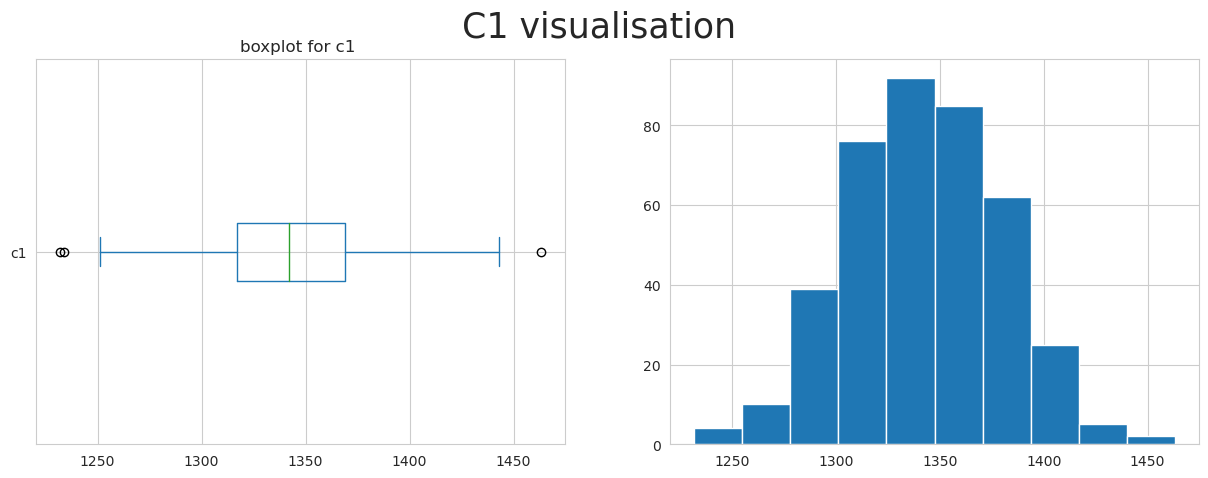

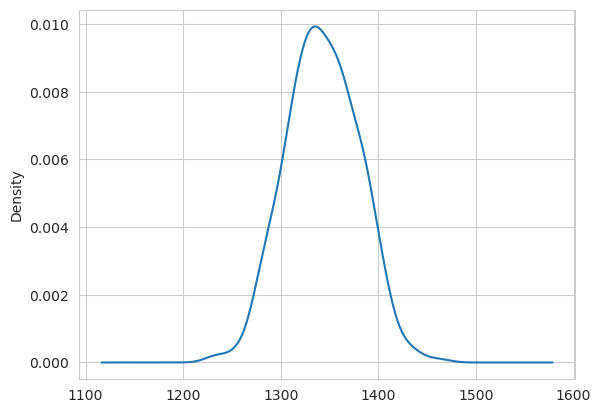


 

----------------------------------------------------------------------------------------------------

 



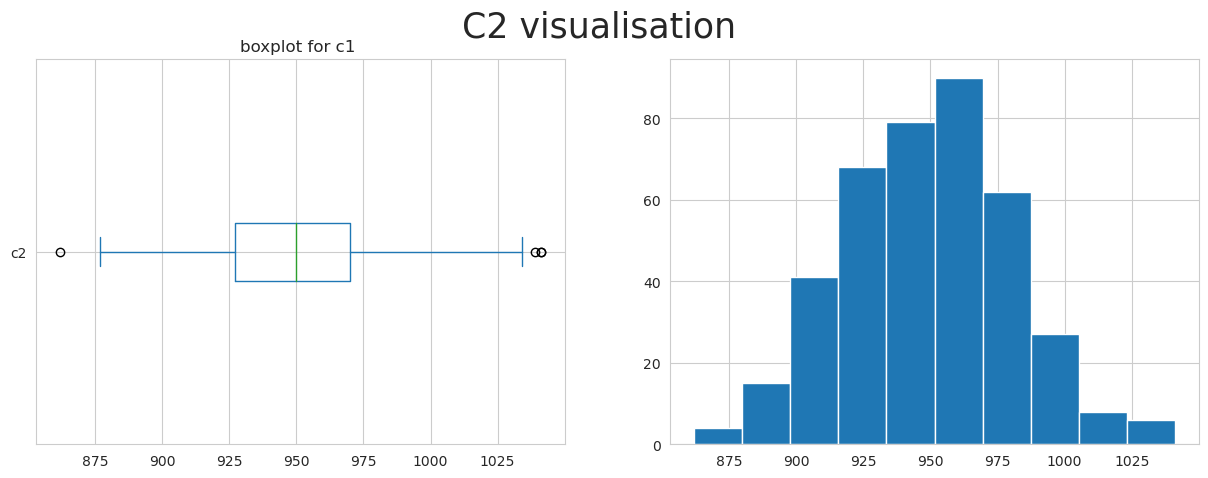

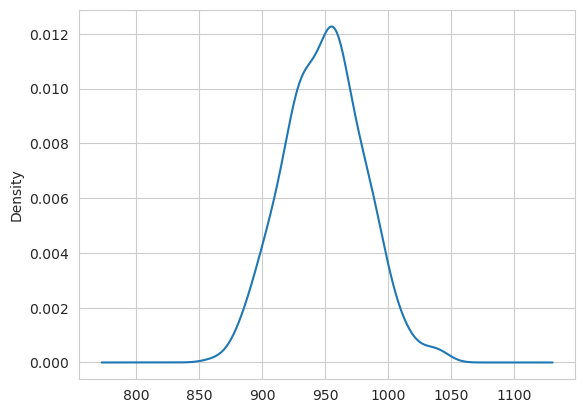


 

----------------------------------------------------------------------------------------------------

 



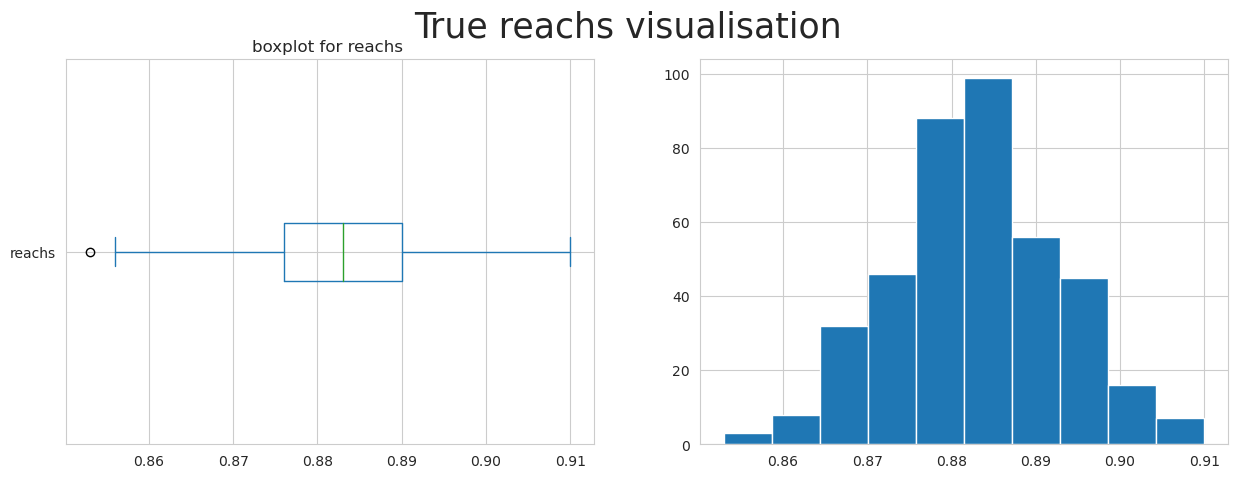

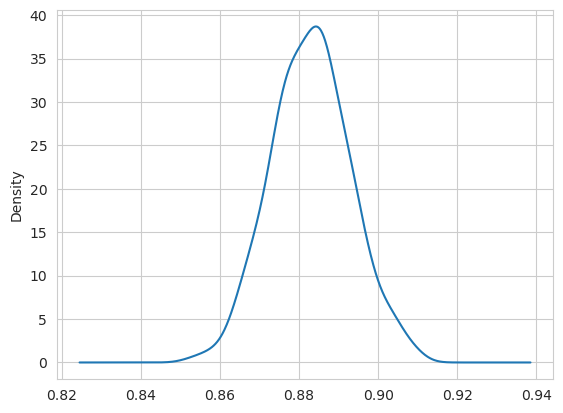

  0%|          | 2/1000 [00:04<40:27,  2.43s/it]

Parameter containing:
tensor([0.5332, 0.1642, 0.3009], device='cuda:0', requires_grad=True)


100%|██████████| 1000/1000 [36:47<00:00,  2.21s/it]


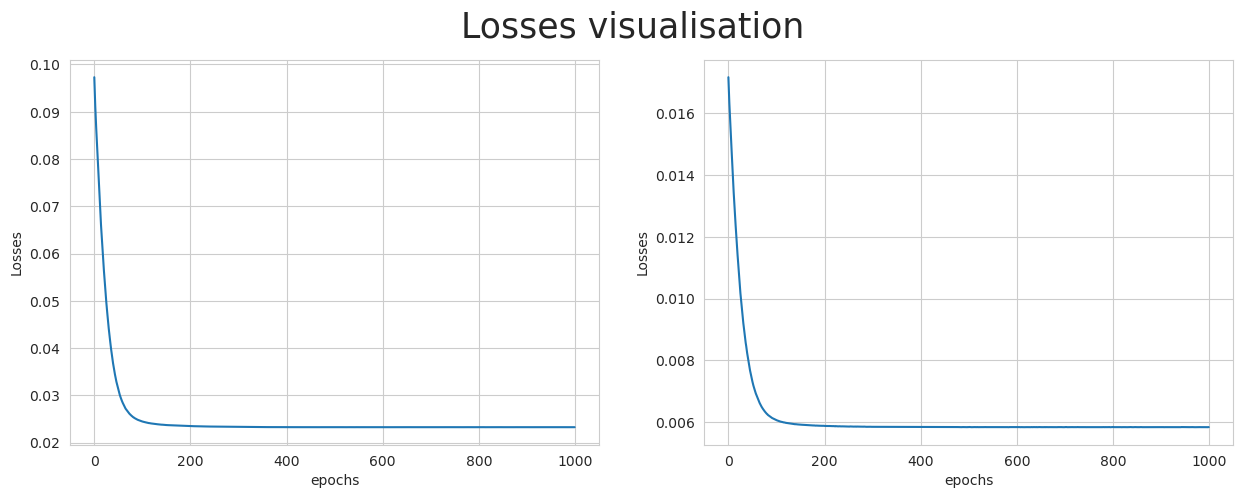

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |        MSE |      RMSE |
|---:|--------------------:|-----------:|----------:|
|  0 |            0.996619 | 0.00101571 | 0.0318702 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.17703245443146662&0.8667734007823651\\0.8777248310462691&0.9851314132731445\\-0.7450481707847575&0.8828890679191251\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.17703245443146662&0.8667734007823651\\0.8777248310462691&0.9851314132731445\\-0.7450481707847575&0.8828890679191251\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (0.6244538318168968, 1.3057873486592526, 0.5089962986786152)$$

la moyenne est : 0.8130791597182548
l ecart type est : 0.3515713584055948


Model()

In [37]:
P=1000
J=2
K=3
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = True 
seed = 43
epochs = 1000
LCM_learning(P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

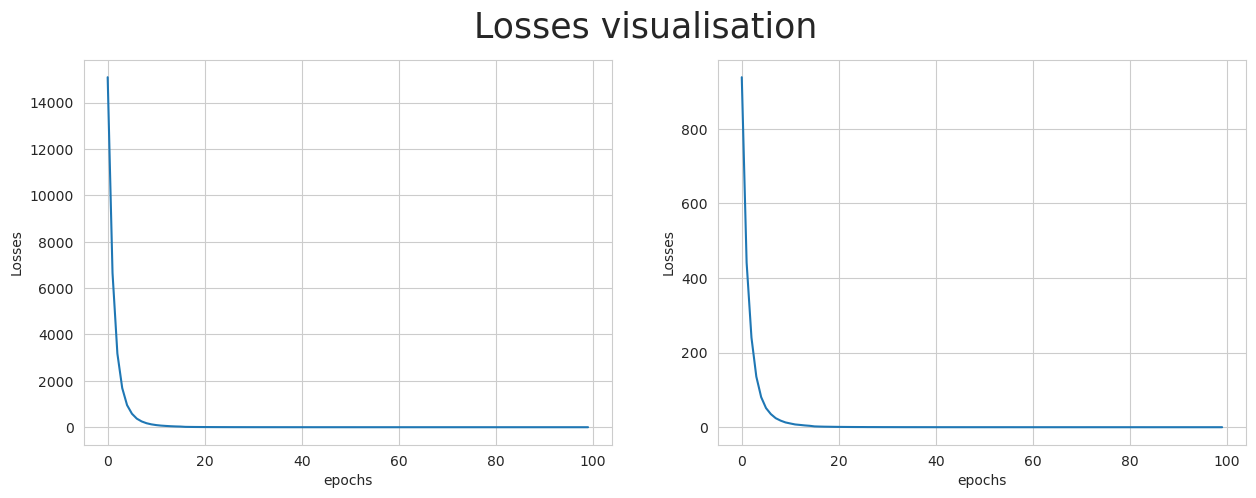

In [35]:
P=50000
J=5
K=9
N_tableaux=400
lr = 0.01
N_train = 350
features_visualisation = False 
epochs = 100
MoyLCM = 0
Mass0 = 0.8
Weight_random = False
prop_panel=0.1
Tableau,True_Z,theta,alpha_proportion,poids_0, L=dataset_LCM(P,J,K,MoyLCM,Mass0,N_tableaux,Weight_random=Weight_random)
reachs = torch.from_numpy(np.array([true_reach (np.delete(Tableau[i].to_numpy(), np.s_[0:1], axis=1) ) for i in range(N_tableaux)]  )).to(device)
cj  = torch.from_numpy(np.array([cj_tab (np.delete(Tableau[i].to_numpy(), np.s_[0:1], axis=1) ) for i in range(N_tableaux)]  )).to(device)
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation,data=(cj,reachs), epochs = epochs)


  0%|          | 2/1000 [00:08<1:12:52,  4.38s/it]

Parameter containing:
tensor([0.3289, 0.1037, 0.1878, 0.2184, 0.0280, 0.1390], device='cuda:0',
       requires_grad=True)


100%|██████████| 1000/1000 [1:20:17<00:00,  4.82s/it]


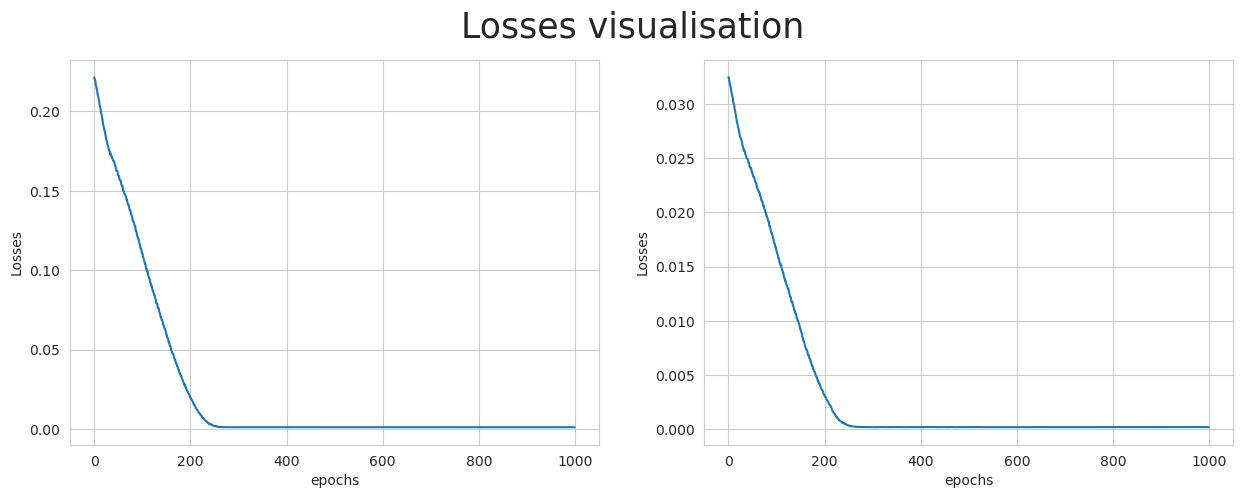

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |        MSE |      RMSE |
|---:|--------------------:|-----------:|----------:|
|  0 |            0.978664 | 0.00179207 | 0.0423329 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}-0.05883034830392413&0.22790289931116586&0.6775231005406703&0.7105322578880592\\-0.5817301231180998&0.5009868163558138&0.6836266697306417&0.7976752828429646\\0.8359071922124583&0.4725602286780244&0.10027999389328252&0.351829461614559\\0.7199273718278199&0.2111725462795139&0.28572259663111793&0.40317247346576124\\-0.20056568115469242&0.7469683781867541&0.9956595153461473&0.9633653338381496\\-0.29177362469751156&-0.6941937674968219&0.7154313860632069&0.6739078913402937\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}-0.05883034830392413&0.22790289931116586&0.6775231005406703&0.7105322578880592\\-0.5817301231180998&0.5009868163558138&0.6836266697306417&0.7976752828429646\\0.8359071922124583&0.4725602286780244&0.10027999389328252&0.351829461614559\\0.7199273718278199&0.2111725462795139&0.28572259663111793&0.40317247346576124\\-0.20056568115469242&0.7469683781867541&0.9956595153461473&0.9633653338381496\\-0.29177362469751156&-0.6941937674968219&0.7154313860632069&0.6739078913402937\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (2.980361320630996, 0.7746020480801146, 3.476170027981069, 1.692084166419377, 1.64486931906267, 1.6515121010699214)$$

la moyenne est : 2.036599830540691
l ecart type est : 0.9106886498970754


In [30]:
P=10000
J=4
K=6
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 1000
model, reachs, reachs_predicted = LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/400 [00:13<45:21,  6.84s/it]

Parameter containing:
tensor([0.1841, 0.0569, 0.1039, 0.1207, 0.0147, 0.0765, 0.1621, 0.1016, 0.0862,
        0.0934], device='cuda:0', requires_grad=True)


100%|██████████| 400/400 [43:03<00:00,  6.46s/it]


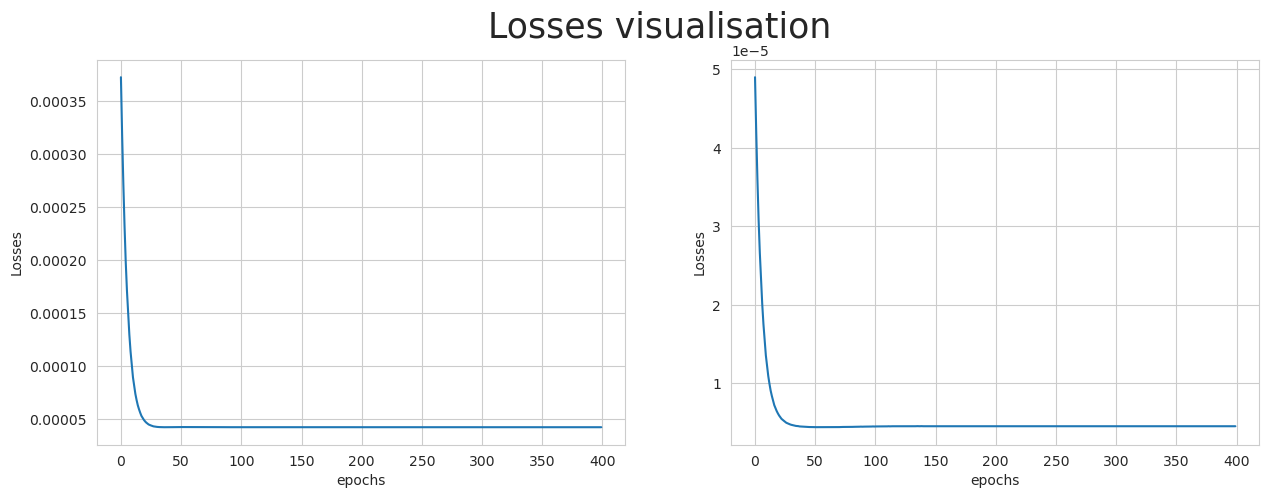

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |         MSE |      RMSE |
|---:|--------------------:|------------:|----------:|
|  0 |            0.975629 | 0.000721295 | 0.0268569 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.46520465996605775&0.06586992279098061&0.7845066761711796&0.5018176321554977&0.6594900798187261&0.577144725079931\\0.7716472884372456&0.7531794383831256&0.41745038985522465&0.7889568115375742&0.8299263789780404&0.8551356547081809\\-0.0333271960191715&0.2716214900290802&0.308036246823138&0.19498548520678538&0.11063947295138049&0.6791556794067245\\0.34933819053317305&-0.11484504453455019&0.2569549688507925&0.5161151809736915&0.0598317884763942&0.6636228199497853\\-0.10739276942529774&0.2864821717674329&0.5528403697198856&0.5764530016069742&0.43952438647705167&0.8482044449117101\\0.367702289238491&0.3734700667583389&-0.03051811096459939&0.7169882206768818&0.7726067974802946&0.820892049074466\\-0.1355655568294554&0.7470084154679663&0.6974581798908811&0.5746763697373932&-0.22322920506834334&0.8178929999739677\\-0.7336530320996223&0.5766456166502507&0.4477946346168682&0.7753904353391953&0.59473667660095&0.5876161143556324\\-0.01798885684489525&0.03984581091126632&0.7739209109755648&0.6805863963271499&0.6631341804856693&-0.028662356580123075\\0.6936062804684627&0.5422335212947463&0.44231956445949955&0.26899364883997473&0.9076240841402075&0.8617775346531389\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.46520465996605775&0.06586992279098061&0.7845066761711796&0.5018176321554977&0.6594900798187261&0.577144725079931\\0.7716472884372456&0.7531794383831256&0.41745038985522465&0.7889568115375742&0.8299263789780404&0.8551356547081808\\-0.0333271960191715&0.2716214900290802&0.308036246823138&0.19498548520678538&0.11063947295138049&0.6791556794067245\\0.34933819053317305&-0.11484504453455019&0.2569549688507925&0.5161151809736915&0.0598317884763942&0.6636228199497853\\-0.10739276942529774&0.2864821717674329&0.5528403697198855&0.5764530016069742&0.43952438647705167&0.8482044449117101\\0.3677022892384909&0.3734700667583389&-0.03051811096459939&0.716988220676882&0.7726067974802946&0.820892049074466\\-0.13556555682945537&0.7470084154679663&0.6974581798908811&0.5746763697373932&-0.22322920506834334&0.8178929999739677\\-0.7336530320996223&0.5766456166502507&0.4477946346168682&0.7753904353391953&0.59473667660095&0.5876161143556324\\-0.017988856844895304&0.03984581091126632&0.7739209109755648&0.6805863963271499&0.6631341804856693&-0.02866235658012313\\0.6936062804684627&0.5422335212947463&0.44231956445949955&0.26899364883997473&0.9076240841402075&0.8617775346531388\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (2.984065112378548, 5.36625698039666, 5.303800267449017, 4.526267064028473, 3.146894427801794, 3.1626201015374744, 4.173402721703694, 2.829685014210152, 4.240475468464871, 3.2031695855799156)$$

la moyenne est : 3.89366367435506
l ecart type est : 0.9101662975926532


Model()

In [ ]:
P=4000
J=6
K=10
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 400
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/1500 [00:19<4:09:00,  9.97s/it]

Parameter containing:
tensor([0.1807, 0.0558, 0.1019, 0.1185, 0.0145, 0.0751, 0.1591, 0.0998, 0.0846,
        0.0917, 0.0183], device='cuda:0', requires_grad=True)


100%|██████████| 1500/1500 [3:06:44<00:00,  7.47s/it]  


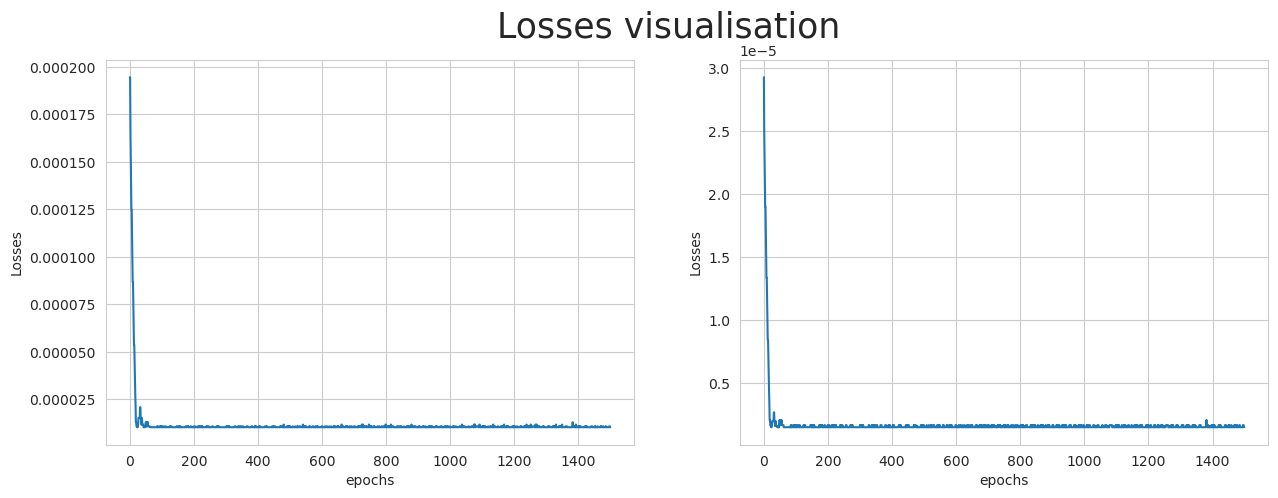

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |         MSE |      RMSE |
|---:|--------------------:|------------:|----------:|
|  0 |            0.975435 | 0.000524241 | 0.0228963 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.8251474890305966&0.34696674050318843&0.517656347125879&0.2077942286268888&0.6568792038673945&0.7711244010388586\\0.49982219673915995&0.3299528826785086&0.7023297137710116&0.6665063314164084&0.8552260961096118&0.7619175207192049\\0.35017623559262534&-0.22753123709834577&0.477822299077933&0.0810503530067575&0.5480843256510892&0.5799587036977568\\-0.1293879711679101&0.20372059328743441&0.2007428095323483&0.2058893391710015&0.7059337107768279&0.799657348367163\\-0.5530411985780559&-0.008544534947663995&0.391889862625282&0.45942363015669513&0.5920641652456055&0.6124929516315749\\0.37067966350253667&0.14558323794303402&0.8986535046740712&0.6395938065723361&0.7998487316177182&0.5413835628775672\\-0.08825165364928708&0.30962206748985766&0.621154484475049&0.18459883749865627&0.05951871582282184&0.37068320829917345\\0.07077209994781303&0.29131713125632136&0.4788052490748861&0.5066202430332274&0.4258494753317429&0.4485105761114\\0.30096514195672325&0.818475895238131&0.6543576739879187&0.6788017915471023&0.3001028387211766&0.7417666472645917\\-0.134043536252762&0.34510118990441935&0.7757320112834065&0.7649905980766113&0.5695473240783935&0.23350565446448956\\-0.1346609138014519&0.4212612364834346&0.21886046409174822&0.2303270618907738&0.6248795047098142&0.7286098119343064\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.8251474890305966&0.34696674050318843&0.517656347125879&0.2077942286268888&0.6568792038673945&0.7711244010388586\\0.49982219673916006&0.32995288267850853&0.7023297137710116&0.6665063314164084&0.855226096109612&0.7619175207192049\\0.35017623559262534&-0.22753123709834577&0.477822299077933&0.08105035300675756&0.5480843256510892&0.5799587036977569\\-0.1293879711679101&0.20372059328743441&0.2007428095323483&0.2058893391710015&0.7059337107768279&0.799657348367163\\-0.5530411985780559&-0.008544534947663995&0.391889862625282&0.45942363015669513&0.5920641652456053&0.6124929516315751\\0.37067966350253667&0.145583237943034&0.8986535046740712&0.6395938065723361&0.7998487316177182&0.5413835628775672\\-0.08825165364928708&0.30962206748985766&0.621154484475049&0.18459883749865627&0.05951871582282181&0.37068320829917345\\0.07077209994781303&0.29131713125632136&0.4788052490748861&0.5066202430332274&0.4258494753317429&0.4485105761114\\0.30096514195672325&0.818475895238131&0.6543576739879187&0.6788017915471023&0.3001028387211766&0.7417666472645917\\-0.13404353625276202&0.34510118990441935&0.7757320112834065&0.7649905980766113&0.5695473240783935&0.23350565446448956\\-0.1346609138014519&0.4212612364834346&0.21886046409174822&0.2303270618907738&0.6248795047098142&0.7286098119343064\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (3.876850335093482, 2.306325497144693, 4.973079770199497, 4.032226370211844, 5.4572241108543444, 3.43780603230352, 4.075798522755767, 4.4688338062250335, 3.218342342762756, 3.6761248872708863, 4.581944497160324)$$

la moyenne est : 4.009505106543831
l ecart type est : 0.8284863537671269


Model()

In [20]:
P=50000
J=6
K=11
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 1500
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/1000 [00:04<33:49,  2.03s/it]

Parameter containing:
tensor([0.5325, 0.1629, 0.3031], device='cuda:0', requires_grad=True)


100%|██████████| 1000/1000 [35:06<00:00,  2.11s/it]


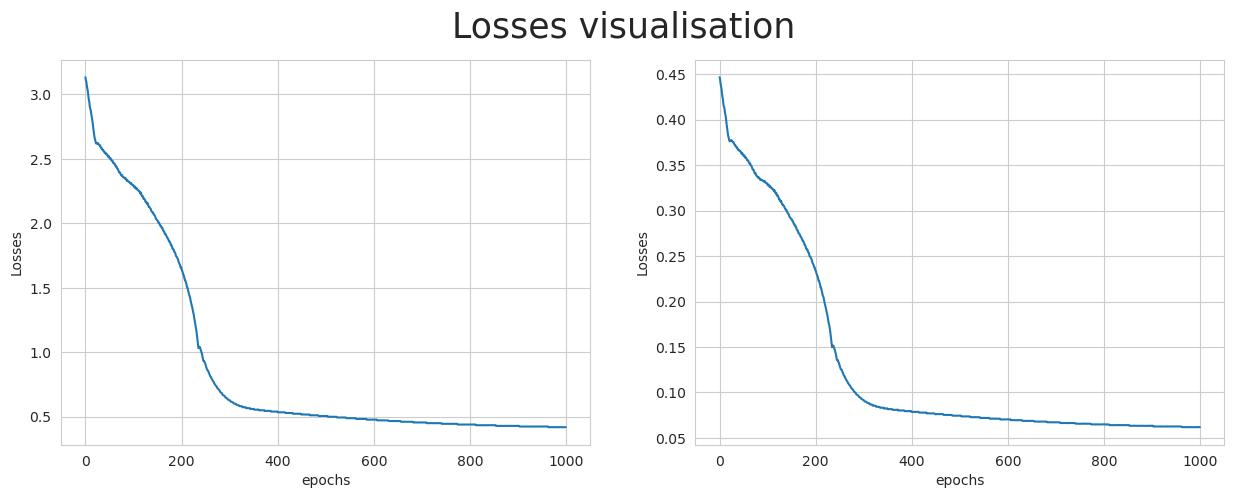

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |       MSE |     RMSE |
|---:|--------------------:|----------:|---------:|
|  0 |            0.944669 | 0.0168062 | 0.129639 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.9621933498789957&0.9907131335470041\\-0.36955572897991784&0.5660000345102529\\0.08071871378871354&0.164415129268868\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.9621933498789957&0.9907131335470041\\-0.36955572897991784&0.5660000345102529\\0.08071871378871354&0.164415129268868\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (1.2325344332318022, 1.350756254764565, 0.5433170149247394)$$

la moyenne est : 1.0422025676403688
l ecart type est : 0.356051677712581


Model()

In [21]:
P=8000
J=2
K=3
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 1000
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/1000 [00:05<41:38,  2.50s/it]

Parameter containing:
tensor([0.5338, 0.1645, 0.3012], device='cuda:0', requires_grad=True)


100%|██████████| 1000/1000 [37:13<00:00,  2.23s/it]


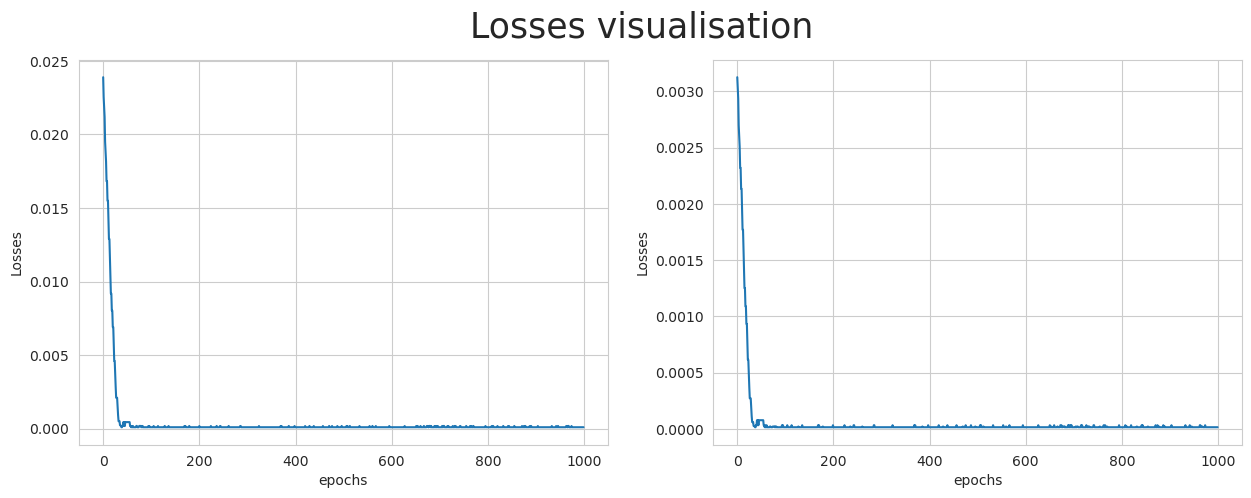

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |        MSE |      RMSE |
|---:|--------------------:|-----------:|----------:|
|  0 |            0.987634 | 0.00411554 | 0.0641524 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}-0.6332744172099687&0.4226031124550347&0.7717783192817907&0.6832998833353932\\0.07731673440201209&0.38037214329569424&0.858345348320472&0.7665993096069663\\0.3820445143697274&0.9083580893602711&0.6396388283948866&0.9313584055370225\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}-0.6332744172099687&0.4226031124550347&0.7717783192817907&0.6832998833353932\\0.07731673440201209&0.38037214329569424&0.858345348320472&0.7665993096069663\\0.3820445143697274&0.9083580893602711&0.6396388283948866&0.9313584055370225\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (3.189654864188149, 1.8905472144404154, 2.350191256284503)$$

la moyenne est : 2.476797778304356
l ecart type est : 0.5378612460302022


Model()

In [22]:
P=50000
J=4
K=3
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 1000
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/1000 [00:07<1:02:30,  3.76s/it]

Parameter containing:
tensor([0.5320, 0.1652, 0.3031], device='cuda:0', requires_grad=True)


100%|██████████| 1000/1000 [51:57<00:00,  3.12s/it]


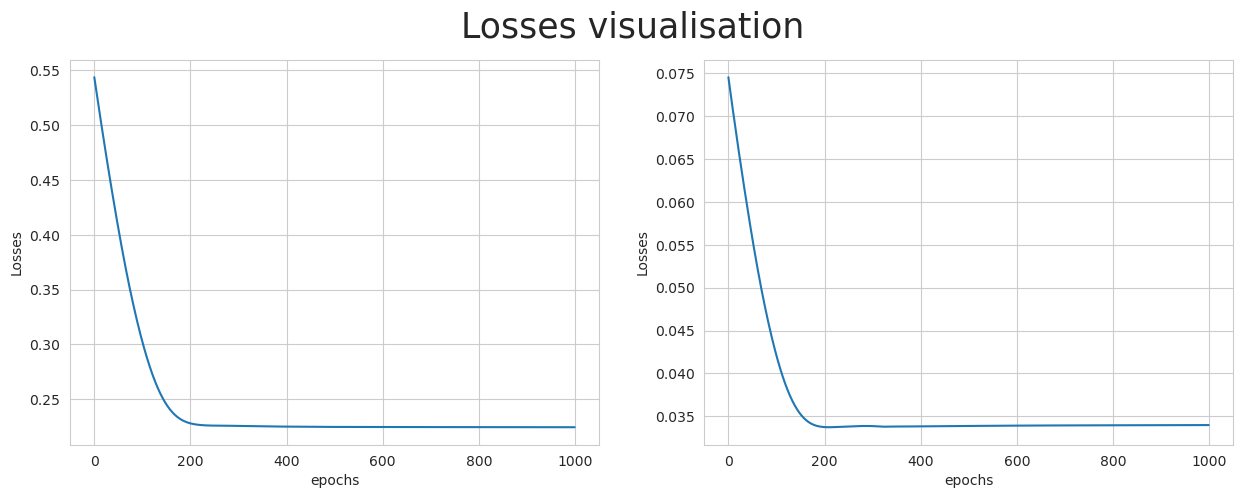

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |        MSE |      RMSE |
|---:|--------------------:|-----------:|----------:|
|  0 |            0.966329 | 0.00915802 | 0.0956976 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.8463833731050843&0.9057049000743449\\0.9744730718373384&0.8661114009825515\\-0.5709767242793764&0.5923738422667704\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.8463833731050843&0.9057049000743449\\0.9744730718373384&0.8661114009825515\\-0.5709767242793764&0.5923738422667704\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (1.2881091977215413, 0.19408862979425498, 1.7039008628011842)$$

la moyenne est : 1.062032896772327
l ecart type est : 0.6367710813798536


Model()

In [18]:
P=100
J=2
K=3
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 1000
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  2%|▏         | 2/100 [00:27<22:39, 13.87s/it]

Parameter containing:
tensor([0.1253, 0.0387, 0.0707, 0.0822, 0.0100, 0.0521, 0.1104, 0.0692, 0.0586,
        0.0636, 0.0127, 0.0802, 0.0088, 0.0893, 0.1283], device='cuda:0',
       requires_grad=True)


100%|██████████| 100/100 [24:41<00:00, 14.82s/it]


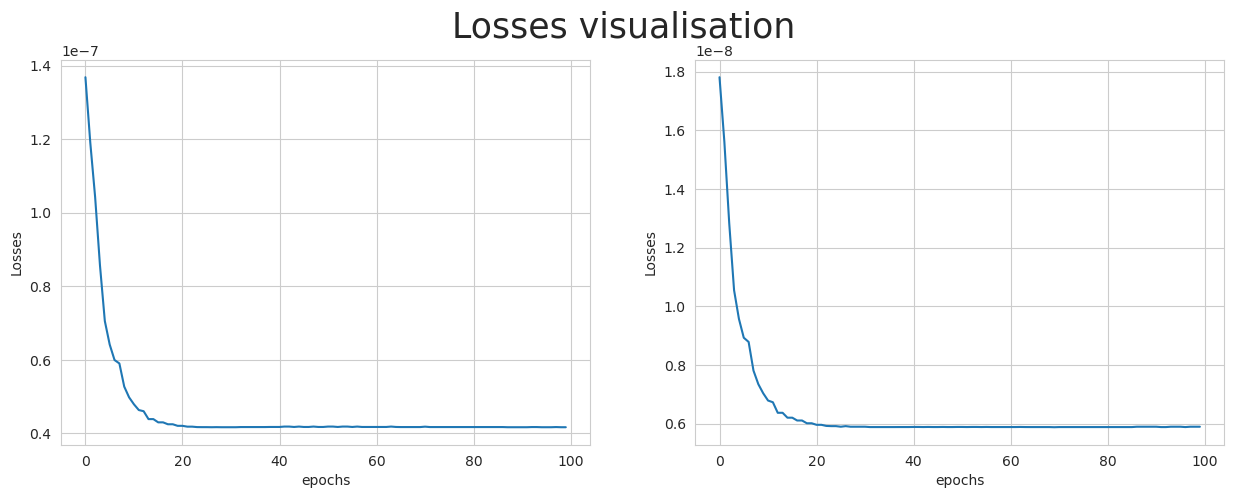

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |         MSE |      RMSE |
|---:|--------------------:|------------:|----------:|
|  0 |            0.989576 | 0.000130673 | 0.0114312 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.1252526423601908&0.24679695446608996&0.2016163255146236&0.09596441574318448&0.15267894665997722&0.6266355500058837&0.529797391099441&0.8974699295985622&0.5800882183107496&0.8104751352746943\\-0.4904785208750244&0.27571176344300774&0.05315749045405385&0.3062001327687347&0.2298672992491099&0.5445149442331623&0.38064826035127997&0.7661140414957787&0.5276904342635115&0.5707552588197987\\0.30805939490334994&-0.1915540521764743&0.32121107202107474&0.036878359075468825&0.7948362053560649&0.2533290916522334&0.28009785307838847&0.5807788485342036&0.6392235533939009&0.5985297828981123\\-0.1631365789278559&0.033830785747414605&0.42142622063675483&0.3481013559645485&0.8028938925199663&0.1877541649042205&0.8296541441750508&0.6451428978020334&0.6863741314200421&0.8748560390153136\\0.4617450296487461&0.5261826997139387&0.28642394326204734&0.4376246395415817&0.6421751357401437&0.5916630904967846&0.6635604665222194&0.6553653520044873&0.7137284144994064&0.7758583083260249\\0.16669179391829841&0.25148476499682954&0.1062514635188932&0.32752357151155587&-0.08033708049491428&0.4489078289286817&0.7800091299724553&0.5551469467861815&0.6464233588324064&0.7669934476557033\\-0.2020880663187538&0.3185632123927223&-0.2670297251956261&-0.005067148249143449&0.5294670970223931&0.26964997085115344&0.42258964313486025&0.6190645926063755&0.861243020275497&0.4169506142292811\\0.015628148923736165&0.32792404535609754&0.04716814367555383&0.15838754175536313&0.5299260508254101&0.31551414214486917&0.6987329759217512&0.3787238008021693&0.32853489352513904&0.6940543700152118\\0.06159067576805732&0.3156295707293404&0.027289987047327532&0.3366400449277378&0.49314532911391407&0.1398576478129308&0.32864005693450404&0.4096015600145072&0.5102299360428733&0.7389611095175577\\0.2480360810855638&0.1864762317923434&0.20080821678641203&0.024883999107712718&0.33098343326912355&0.5772921932094286&0.33995919925948836&0.33430139281884363&0.6790973323767872&0.5369974001580045\\-0.166800268486057&0.15079001719705049&0.24583077818146631&0.13456362433074262&0.2196309453095206&0.6091036809484923&0.4950212180997691&0.46290242342529797&0.5457829158565383&0.7762480694179731\\0.19921288001386228&-0.2991451482516341&0.16766583532183377&0.30488276504258843&0.10001330887048802&0.4868103561214939&0.7097984973951077&0.5427645949718289&0.6110128656035471&0.4876983947834659\\0.15192917422557276&-0.5057467962617248&0.16972190529767842&0.5189174656603477&0.46953700294346995&0.4913859881556122&0.46639917861027297&0.8392109909958472&0.7313390889914724&0.8699511026837139\\0.0010137348346632158&-0.13246034536158544&0.46971745043060775&-0.19719880463064826&0.8770130988782174&0.4287756877968776&0.5842048186932427&0.5352199010773631&0.722860562700898&0.7155574989431516\\-0.4512596135294402&0.46497623628097684&0.2877035076440665&0.29565052158854394&0.5033715203277498&0.7616336866423081&0.2899594865490247&0.8647145819057291&0.7903522819787573&0.8591868363196226\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.1252526423601908&0.24679695446608996&0.2016163255146236&0.09596441574318448&0.15267894665997722&0.6266355500058837&0.529797391099441&0.8974699295985622&0.5800882183107496&0.8104751352746944\\-0.4904785208750244&0.27571176344300774&0.05315749045405385&0.3062001327687347&0.2298672992491099&0.5445149442331623&0.3806482603512801&0.7661140414957787&0.5276904342635115&0.5707552588197988\\0.30805939490334994&-0.1915540521764743&0.32121107202107474&0.036878359075468825&0.7948362053560647&0.2533290916522334&0.28009785307838847&0.5807788485342036&0.6392235533939009&0.5985297828981124\\-0.1631365789278559&0.033830785747414605&0.42142622063675483&0.3481013559645485&0.8028938925199662&0.18775416490422056&0.8296541441750508&0.6451428978020334&0.6863741314200419&0.8748560390153136\\0.4617450296487461&0.5261826997139386&0.2864239432620473&0.4376246395415817&0.6421751357401437&0.5916630904967846&0.6635604665222193&0.6553653520044873&0.7137284144994063&0.7758583083260248\\0.16669179391829836&0.25148476499682954&0.1062514635188932&0.32752357151155587&-0.08033708049491428&0.4489078289286817&0.7800091299724553&0.5551469467861815&0.6464233588324064&0.7669934476557033\\-0.2020880663187538&0.3185632123927223&-0.2670297251956262&-0.005067148249143394&0.5294670970223931&0.26964997085115344&0.42258964313486025&0.6190645926063756&0.861243020275497&0.4169506142292811\\0.015628148923736165&0.32792404535609754&0.04716814367555383&0.15838754175536313&0.5299260508254101&0.31551414214486917&0.6987329759217512&0.3787238008021693&0.3285348935251391&0.6940543700152118\\0.06159067576805732&0.3156295707293404&0.027289987047327532&0.3366400449277378&0.49314532911391407&0.1398576478129308&0.32864005693450404&0.4096015600145072&0.5102299360428733&0.7389611095175577\\0.2480360810855638&0.1864762317923434&0.20080821678641203&0.024883999107712718&0.3309834332691236&0.5772921932094286&0.33995919925948836&0.33430139281884363&0.6790973323767872&0.5369974001580046\\-0.166800268486057&0.15079001719705054&0.24583077818146631&0.1345636243307426&0.2196309453095206&0.6091036809484923&0.495021218099769&0.46290242342529797&0.5457829158565383&0.7762480694179731\\0.19921288001386228&-0.2991451482516341&0.16766583532183377&0.30488276504258843&0.10001330887048804&0.4868103561214939&0.7097984973951077&0.5427645949718289&0.6110128656035471&0.4876983947834659\\0.15192917422557264&-0.5057467962617247&0.16972190529767842&0.5189174656603477&0.46953700294346995&0.4913859881556122&0.46639917861027297&0.8392109909958472&0.7313390889914724&0.8699511026837141\\0.0010137348346632158&-0.13246034536158544&0.46971745043060775&-0.19719880463064826&0.8770130988782172&0.4287756877968776&0.5842048186932427&0.5352199010773631&0.722860562700898&0.7155574989431515\\-0.4512596135294402&0.46497623628097684&0.2877035076440665&0.29565052158854394&0.5033715203277498&0.7616336866423081&0.2899594865490246&0.8647145819057291&0.7903522819787573&0.8591868363196226\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (8.48499786439969, 6.818695134450626, 7.3340933539255, 9.414584614991366, 7.410018667926, 8.688517251964948, 10.374183366089353, 9.274541574920832, 8.239348165887824, 8.009386887079657, 9.909241486626811, 7.594735490719903, 7.4058938408885435, 7.638205749692204, 7.050317680875668)$$

la moyenne est : 8.243117408695927
l ecart type est : 1.0495873126268707


Model()

In [20]:
P=40000
J=10
K=15
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 100
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  1%|▏         | 2/150 [00:21<26:53, 10.91s/it]

Parameter containing:
tensor([0.1810, 0.0562, 0.1015, 0.1187, 0.0147, 0.0753, 0.1588, 0.1004, 0.0848,
        0.0915, 0.0181], device='cuda:0', requires_grad=True)


100%|██████████| 150/150 [24:04<00:00,  9.63s/it]


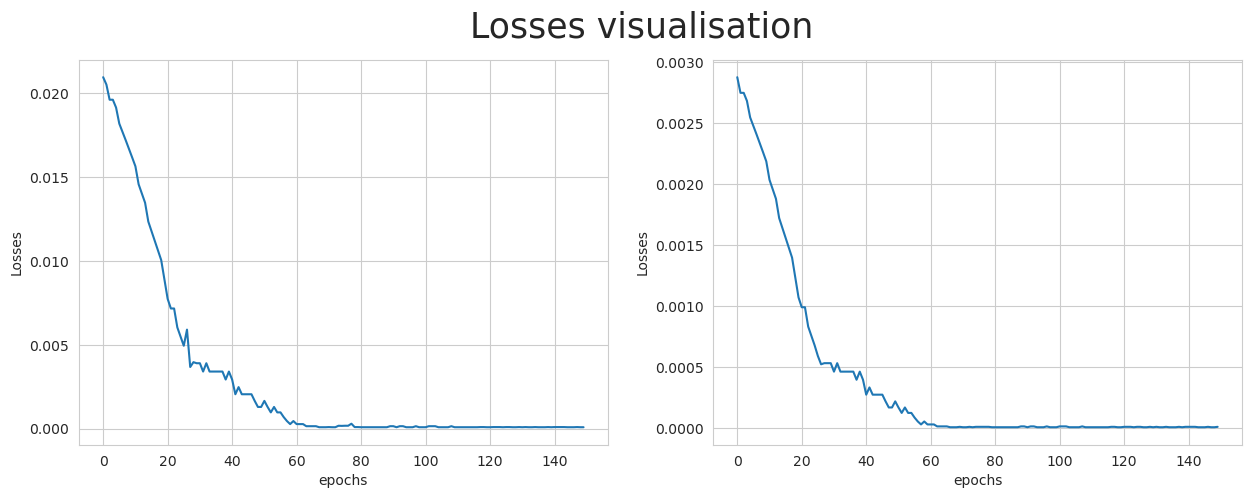

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |         MSE |      RMSE |
|---:|--------------------:|------------:|----------:|
|  0 |             0.99182 | 0.000177258 | 0.0133138 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.13137113836596348&0.42004134709724583&0.5265711098311304&0.591316507820564&0.7448870185931745&0.7105141274954645\\0.6636509328470744&0.17629568204950402&-0.1328166184558232&0.6916178504193714&0.6264493633736493&0.8488571603967262\\-0.6144886442950819&0.44188786296049626&-0.12734981174861768&0.5903882980071956&0.9239852050661719&0.8714717165025111\\0.2376882652135757&0.40733323973617663&-0.20335000660267566&0.26706799001738885&0.6030243851865617&0.7480493383881461\\0.09195530750153764&0.025240982167862414&-0.30800047402608055&0.22836515129779172&0.5514698587675432&0.9118312529537638\\-0.41063542936557007&0.4457427506784327&0.9242801881102445&0.4239950639049288&0.401788408576348&0.6520434635745522\\-0.27094217107830953&0.583413322319064&0.7864323104952298&0.5038522769681396&0.7743550354153674&0.6478326919055952\\0.6891661670267158&-0.3074907076490471&0.7201623081909814&0.7923224527806438&0.5692981009396033&0.8903308658750528\\-0.1613646005458019&0.8811921853824393&0.3169722684350524&0.8323616763595374&0.7077460707218426&0.7179913760200709\\0.06162433221371035&0.279076276628345&0.0054223662913922555&0.6088523340805634&0.4451308084434393&0.4837709815537299\\0.14821335154126525&0.21717157326711947&0.09701238630441955&0.39331523078579234&0.44882790813276574&0.8025678519379164\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.13137113836596354&0.42004134709724583&0.5265711098311304&0.591316507820564&0.7448870185931745&0.7105141274954644\\0.6636509328470744&0.17629568204950402&-0.13281661845582327&0.6916178504193714&0.6264493633736493&0.8488571603967262\\-0.614488644295082&0.44188786296049626&-0.12734981174861768&0.5903882980071956&0.9239852050661719&0.8714717165025111\\0.2376882652135757&0.40733323973617663&-0.20335000660267571&0.26706799001738885&0.6030243851865617&0.7480493383881461\\0.09195530750153764&0.025240982167862414&-0.30800047402608055&0.22836515129779172&0.5514698587675432&0.9118312529537639\\-0.41063542936557007&0.4457427506784327&0.9242801881102444&0.4239950639049288&0.401788408576348&0.6520434635745522\\-0.27094217107830953&0.583413322319064&0.7864323104952298&0.5038522769681396&0.7743550354153674&0.6478326919055951\\0.6891661670267157&-0.3074907076490471&0.7201623081909814&0.7923224527806438&0.5692981009396033&0.8903308658750527\\-0.16136460054580187&0.8811921853824393&0.31697226843505233&0.8323616763595374&0.7077460707218426&0.7179913760200709\\0.061624332213710296&0.279076276628345&0.0054223662913922555&0.6088523340805634&0.4451308084434393&0.4837709815537299\\0.14821335154126525&0.21717157326711947&0.09701238630441955&0.39331523078579234&0.44882790813276574&0.8025678519379165\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (3.7788552644132594, 2.389969243568804, 3.596050663500735, 4.826347460488979, 5.626102559621883, 4.397057285012188, 3.0176557983674956, 2.6249579862395573, 3.3781132489079377, 4.012435167909584, 3.8598712882261945)$$

la moyenne est : 3.773401451477875
l ecart type est : 0.9038529552098252


Model()

In [28]:
P=50000
J=6
K=11
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 150
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/2000 [00:12<3:35:57,  6.49s/it]

Parameter containing:
tensor([0.2243, 0.0693, 0.1265, 0.1472, 0.0180, 0.0932, 0.1976, 0.1239],
       device='cuda:0', requires_grad=True)


100%|██████████| 2000/2000 [4:02:42<00:00,  7.28s/it]  


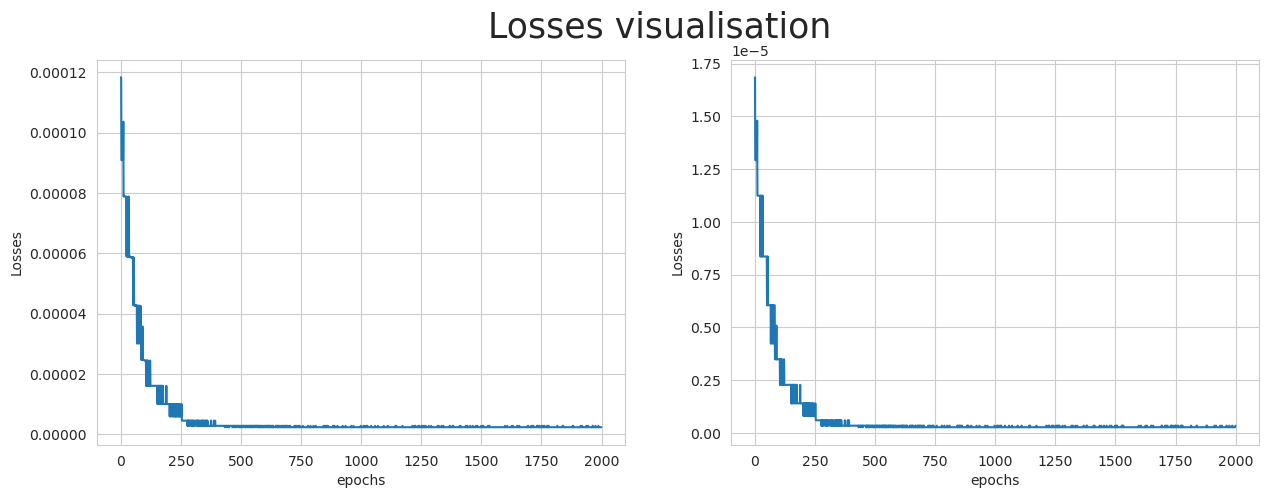

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |       MSE |      RMSE |
|---:|--------------------:|----------:|----------:|
|  0 |            0.981121 | 0.0008269 | 0.0287559 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.5027774030719888&0.4316494152475344&0.3386286661819382&0.5086017555991214&0.7317373800463828&0.4139576756876121\\0.4973598909208506&0.08296719811711362&0.21283113289598293&0.415557283037484&0.617847803526554&0.3821010617612085\\0.4825716689247547&-0.016417026723142783&-0.047529883145804835&0.4883109073237584&0.6580180572198229&0.7274929797298896\\0.32091904207913724&-0.5061584499074752&0.7759768951450257&0.12485517548183606&0.8041471884395143&0.7252470008693308\\-0.6756129039347648&0.5078140867314296&0.4734394552916713&0.4427823275621733&0.8737786266380689&0.9688381471383641\\0.1919649349242903&-0.20199325236347687&0.23108951845639145&0.5616796023307091&0.47718285808161937&0.7648149793109565\\-0.058326155496430575&0.5099971395593635&0.006865185767035112&0.5713789279757664&0.8283479360238902&0.564984385089862\\0.3279990640429302&0.0918645676108237&0.26998058299432215&0.6939324874027126&0.5013736776492089&0.35218964353934834\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.5027774030719889&0.43164941524753436&0.3386286661819382&0.5086017555991214&0.7317373800463828&0.4139576756876121\\0.49735989092085064&0.08296719811711362&0.21283113289598293&0.415557283037484&0.617847803526554&0.3821010617612084\\0.4825716689247546&-0.016417026723142783&-0.047529883145804835&0.4883109073237584&0.6580180572198229&0.7274929797298896\\0.32091904207913724&-0.5061584499074752&0.7759768951450257&0.12485517548183606&0.8041471884395143&0.7252470008693308\\-0.6756129039347648&0.5078140867314296&0.4734394552916714&0.4427823275621733&0.8737786266380689&0.9688381471383641\\0.1919649349242903&-0.20199325236347687&0.23108951845639145&0.5616796023307091&0.47718285808161937&0.7648149793109565\\-0.05832615549643059&0.5099971395593635&0.006865185767035056&0.5713789279757664&0.8283479360238902&0.564984385089862\\0.3279990640429302&0.0918645676108237&0.26998058299432215&0.6939324874027126&0.5013736776492089&0.35218964353934834\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (3.553434561293716, 3.6426554466665024, 3.2159988507123103, 2.072583235494282, 4.207386468015504, 4.015725482428741, 5.164289972637067, 2.376825027695964)$$

la moyenne est : 3.531112380618011
l ecart type est : 0.9308187779556959


Model()

In [31]:
P=100000
J=6
K=8
N_tableaux=400
lr = 0.0001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 2000
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/500 [00:09<34:58,  4.21s/it]

Parameter containing:
tensor([0.5356, 0.1666, 0.2995], device='cuda:0', requires_grad=True)


100%|██████████| 500/500 [24:22<00:00,  2.93s/it]


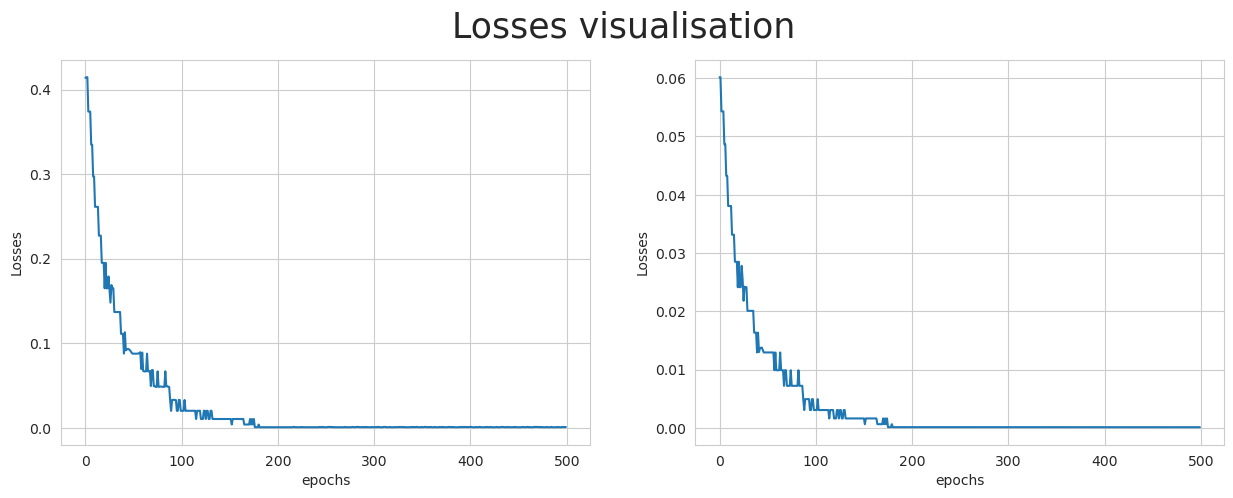

Evaluation sur $(q_k)_{k=1} ^ {K}$ et son estimation après le modèle : 

|    |   Cosine similarity |        MSE |     RMSE |
|---:|--------------------:|-----------:|---------:|
|  0 |            0.992778 | 0.00203158 | 0.045073 |


Evaluation sur $(\Sigma^{(k)})_{k=1} ^ {K}$ et son estimation après le modèle : 

La cosine similarity sur les lignes de chaque matrice (la ligne 1 est la cosine similarity sur les lignes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.7518108543212048&0.19899006176831346\\-0.5037705046861063&0.8666103590390581\\0.24233906650249096&0.9756476412047455\\\end{bmatrix}

La cosine similarity sur les colonnes de chaque matrice (la ligne 1 est la cosine similarity sur les colonnes sur la matrice de correlation et la la matrice de correlation estimée), nous donne : 

\begin{bmatrix}0.7518108543212048&0.19899006176831346\\-0.5037705046861063&0.8666103590390581\\0.24233906650249096&0.9756476412047455\\\end{bmatrix}

Maintenant nous allons calculer $\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} $ pour tout $k \in [K]$ et où $\lVert .\Vert_{F}$ est la norme Frobenius :

$$(\lVert  \widehat{\Sigma^{(k)}} - \Sigma^{(k)} \Vert_{F} )_{k=1} ^ {K} = (1.1428125822682211, 0.7848121293365391, 0.13395708609117102)$$

la moyenne est : 0.6871939325653105
l ecart type est : 0.4176077404273938


Model()

In [14]:
P=100000
J=2
K=3
N_tableaux=400
lr = 0.001
N_train = 350
features_visualisation = False 
seed = 43
epochs = 500
LCM_learning (P,J, K, N_tableaux, N_train, lr = lr, features_visualisation = features_visualisation, seed = seed, epochs = epochs)

  0%|          | 2/2000 [00:12<3:27:25,  6.23s/it]

Parameter containing:
tensor([0.2570, 0.0771, 0.1427, 0.1675, 0.0213, 0.1045, 0.2275],
       device='cuda:0', requires_grad=True)


100%|██████████| 2000/2000 [3:23:40<00:00,  6.11s/it]  


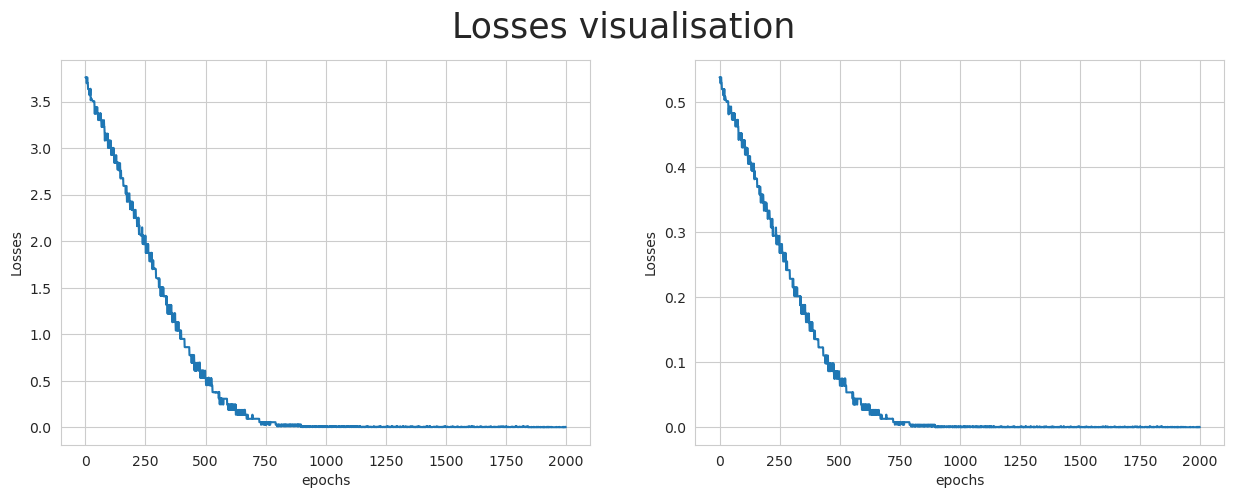

|    |   Cosine similarity |         MSE |       RMSE |
|---:|--------------------:|------------:|-----------:|
|  0 |            0.999999 | 1.93913e-06 | 0.00139253 |


Model()

In [15]:
P=100000
J=4
K=7
N_tableaux=400
lr =  0.001
N_train = 350
features_visualisation = False 
epochs = 2000
MoyLCM = 0
Mass0 = 0.8
Weight_random = False
prop_panel=0.1
init = [-20,20]
Tableau,True_Z,theta,alpha_proportion,poids_0=dataset_LCM(P,J,K,MoyLCM,Mass0,N_tableaux,Weight_random=Weight_random)
reachs = torch.from_numpy(np.array([true_reach (np.delete(Tableau[i].to_numpy(), np.s_[0:1], axis=1) ) for i in range(N_tableaux)]  )).to(device)
cj  = torch.from_numpy(np.array([cj_tab (np.delete(Tableau[i].to_numpy(), np.s_[0:1], axis=1) ) for i in range(N_tableaux)]  )).to(device)
LCM_learning (P,J, K, N_tableaux, N_train, lr = 0.001, features_visualisation = features_visualisation,data=(cj,reachs), epochs = epochs)

